In [1]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
import time
import pickle

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import sys
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
from ICET_spherical import ICET
from utils import *
from metpy.calc import lat_lon_grid_deltas
from pioneer.das.api.platform import Platform
from scipy.spatial.transform import Rotation as R
from pioneer.das.api.egomotion.imu_egomotion_provider import IMUEgomotionProvider as emp 
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

2023-05-03 18:04:59.956323: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 18:05:00.048179: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-03 18:05:00.420780: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/cv2/../../lib64:
2023-05-03 18:05:00.420829: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_p

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-05-03 18:05:00.983693: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 18:05:00.984379: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-03 18:05:00.984551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-03 18:05:00.984671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Autosaving every 180 seconds


# Goal: Simultaneously Estimate Translation, Rotation, and Distortion

## $\mathbf{A} = [\hat{X}_{ij}, \hat{m}_{ij}] = 
\begin{bmatrix}
% x, ~ y, ~ z, ~ \phi, ~ \theta, ~ \psi, ~ x^+, ~y^+, ~z^+, ~\phi^+, ~\theta^+, ~\psi^+ \\
x, ~ y, ~ z, ~ \phi, ~ \theta, ~ \psi, ~ x^+, ~y^+, ~z^+, ~\phi^+, ~\theta^+, ~\psi^+ \\
\end{bmatrix}$

We can use newton-raphson to find A

<!-- ## $y_i = \mathbf{h}(y_j, \hat{X}_{ij}, \hat{m}_{ij}) + \mathbf{H}_m \delta m + \mathbf{H}_x \delta x + \text{H.O.T.}$ -->

## $y_i = \mathbf{h}(y_j, \hat{A}_{ij}) + \mathbf{H}_A \delta A + \text{H.O.T.}$

## $\mathbf{H}_A \in \mathbb{R}^{4N \times 12} $



### $\mathbf{H}_A = [H_X, H_m]$

# Problem:  what if distortion correction and rigid transform both work equally well?

(ex: there are not enough features on one side to completely enclose the vehicle)

### IT MAKES LIFE WAY EASIER IF I SUPPRESS ANGULAR COMPONENT OF MOTION PROFILE 

### Run Demo

In [269]:
# load point cloud
# # no distortion
# old_cloud =  np.load("sample_data/paper_figures/case1/raw_frame_0.npy")
# # m_hat = np.array([0., 0., 0., 0., 0., 0.0]) #actual motion
# m_hat = np.array([-3., 0., 0., 0., 0., 0.1]) #test wrap around

# # movement in x
# old_cloud =  np.load("sample_data/paper_figures/case2/raw_frame_3.npy") 
# m_hat = np.array([3, 0, 0., 0., 0., 0])
# # m_hat = np.array([0., 0, 0., 0., 0., 0.]) #FOR DEBUG-- deform just a little
# gt =  np.load("sample_data/paper_figures/case2/base_vel_2.npy")

# movement in x, y, & yaw
old_cloud =  np.load("sample_data/paper_figures/case3/raw_frame_1.npy") 
# m_hat = np.array([3, -1, 0., 0., 0., -1])
m_hat = np.array([3, -1, 0., 0., 0., -0.86]) #FOR DEBUG-- deform a little extra
# m_hat = np.array([0., 0., 0., 0., 0., 0.0]) #FOR DEBUG-- no deformation
gt =  np.load("sample_data/paper_figures/case3/base_vel_2.npy")
# print(gt) 

# period_lidar = 1
# t_scale = (2*np.pi)/(-m_hat[-1] + (2*np.pi/period_lidar))
# print(t_scale)
# m_hat = m_hat*t_scale
# # m_hat[-1] = m_hat[-1]*t_scaled
# print(m_hat)

#downsample
old_cloud = old_cloud[::5,:]

In [270]:
from remove_motion_basic import linear_correction_old as lc 

#apply ground truth distortion according to m_hat
new_cloud = lc(old_cloud, m_hat) 
#set ground truth transform between clouds
# X_gt = np.array([0, 0., 0.0, 0.0, 0.0, 0.0])
# X_gt = np.array([1.5, 0.5, 0.03, 0.03, 0.03, 0.25])
# X_gt = np.array([1.5, -3, 0.1, 0.2, 0.03, -0.15])
X_gt = np.array([-1., 0., 0.0, 0., 0., 0.])

# add noise
old_cloud += 0.01*np.random.randn(np.shape(old_cloud)[0], 3)

# #for fig: mess up both again to show that relative distortion remains constant
# new_cloud = lc(new_cloud, -m_hat)
# old_cloud = lc(old_cloud, -m_hat)
# old_cloud = lc(old_cloud, 0.2*m_hat)

# #remove ground plane
# old_cloud = old_cloud[old_cloud[:,2] > -1] 
# new_cloud = new_cloud[new_cloud[:,2] > -1] 

#remove left half of each point cloud
# old_cloud = old_cloud[:(len(old_cloud)//2),:]
# new_cloud = new_cloud[:(len(new_cloud)//2),:]
# # 2/3 of each point cloud
# old_cloud = old_cloud[:(len(old_cloud)//3),:]
# new_cloud = new_cloud[:(len(new_cloud)//3),:]

# #get rid of two walls but leave ground plane
# a = np.where(old_cloud[:,2] < -1.4) 
# b = np.where(old_cloud[:,1] > 0)
# c = np.where(old_cloud[:,0] > -8)
# idx = np.union1d(np.intersect1d(b,c),a)
# old_cloud = old_cloud[idx]
# new_cloud = new_cloud[idx]

# Rotate + Translate new point cloud
trans = X_gt[:3]
rot = R_tf(X_gt[3:]).numpy()
new_cloud = (new_cloud @ rot) + trans

plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
disp.append(Points(old_cloud, c = "#CB2314")) 
disp.append(Points(new_cloud, c = "#2c7c94")) 
plt.show(disp, "raw point clouds")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

### Attempt to solve with basic 6 state solution (Impossible)

In [ ]:
from linear_corrector import LC
pc1 = old_cloud
pc2  = new_cloud
m_hat0 = np.array([0, 0, 0, 0, 0, 0.])
dc = LC(cloud1 = pc2, cloud2 = pc1, fid = 50, niter = 20, draw = True, 
        m_hat0 = m_hat0,  mnp = 25, RM = False, solver='6_state')
ViewInteractiveWidget(dc.plt.window)


### Run Newton-Raphson with a priori correspondences

In [ ]:
A_hat = np.array([0., 0, 0, 0, 0, 0, 
                  0, 0, 0, 0, 0, 0])
skip = 1 #50
y_i = new_cloud[::skip] #baseline
y_j = old_cloud[::skip] #distorted cloud

print("num corr total:", len(y_i))

plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
disp.append(Points(y_i[:,:3], c = "#a65852 ", alpha = 0.5, r=5.5)) #

runlen = 5
for count in range(runlen):
    
    print("~~~~ iteration ", count, "~~~~~~~~~~~")
    print("A_hat = \n", np.round(A_hat[:6],4), "\n", np.round(A_hat[6:],4)) 
    
    #decompose A_hat into X_hat and m_hat
    X_hat = A_hat[:6] 
    m_hat = A_hat[6:]
#     X_hat = np.array([0, 0, 0, 0, 0, 0.]) #for debug
#     m_hat = np.array([0, 0, 0, 0, 0, 0.]) #for debug
#     m_hat = 0.1*m_hat
    
    #apply last estimate of distortion correction
#     print("m_hat", m_hat)
    y_j_undistort = lc(y_j, m_hat)

    #apply last rigid transform
    rot = R_tf(X_hat[3:]).numpy()
    trans = X_hat[:3]
    y_j_undistort = (y_j_undistort @ rot) + trans
    
#     print("rot: \n", rot,"\n trans: \n", trans)  
#     print("\n y_i \n",np.shape(y_i), "\n", y_i[:3])
#     print("y_j_undistort \n",np.shape(y_j_undistort), "\n", y_j_undistort[:3])

    
    #get H = [H_X, H_m]
    #get jacobain of distortion correction function
    H_m = dc.get_H_m(y_j_undistort, m_hat) 
#     print("\n H_m:", np.shape(H_m), "\n", H_m[:10])
    
    #get jacobian of rigid transform function 
    H_x = jacobian_tf(tf.transpose(tf.convert_to_tensor(y_j_undistort, tf.float32)), tf.convert_to_tensor(X_hat[3:], tf.float32)) # shape = [num of corr * 3, 6]
    #need to append on a row of zeros since we are working with homogeneous coordinates!
    H_x = tf.reshape(H_x, (tf.shape(H_x)[0]//3, 3, 6)) # -> need shape [#corr//4, 4, 6]
#     print("\n H_x before:", np.shape(H_x), "\n", H_x[0])
    H_x = tf.concat([H_x, tf.zeros([len(H_x),1,6])], axis = 1)
    H_x = tf.reshape(H_x, (-1, 6))
#     print("\n H_x after:", np.shape(H_x), "\n", H_x[:10])
    H_x = H_x.numpy()
        
    #delta_A =  ((H^T*H)^-1)(H^T)(yi - yj_undistort)
    residual = (np.append(y_i, np.ones([len(y_i),1]), axis = 1) -
                np.append(y_j_undistort, np.ones([len(y_i),1]), axis = 1)).flatten()
#     print("residual", np.shape(residual), "\n", residual)
    
    H = np.append(H_x, H_m, axis = 1)
    print("H: \n", np.shape(H))

    print("pinv(HTH): \n", np.shape(np.linalg.pinv(H.T @ H)))
    print("pinv(HTH) @ H.T: \n", np.shape(np.linalg.pinv(H.T @ H) @ H.T))
    
    delta_A = np.linalg.pinv(H.T @ H) @ H.T @ residual
    print("\n delta_A \n", np.round(delta_A[:6], 5), "\n", np.round(delta_A[6:], 5))
    #augment rigid transform components
    A_hat[:6] -=   delta_A[:6]
    #augment distortion components
    A_hat[6:9] -= delta_A[6:9]
    A_hat[9:] += delta_A[9:]

    #plot updated cloud2
#     color = [0.5 + count/(runlen*2), 1 - (count+1)/runlen, (count+1)/runlen]
#     disp.append(Points(y_j_undistort[:,:3], c = color, r=3.5))
    disp.append(Points(y_j_undistort[:,:3], c = "#2c7c94 ", alpha = (count+1)/(runlen+1), r=3.5))

    
plt.show(disp, "12 State Solution")
ViewInteractiveWidget(plt.window)

# Run again with voxel-based correspondences

In [273]:
from linear_corrector import LC

A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
print("actual X, m: \n", X_gt, "\n", m_hat )

dc = LC(cloud1 = new_cloud, cloud2 = old_cloud, fid = 40, niter = 15, 
        draw = True, mnp = 25, RM = False, solver = '12_state', 
        max_buffer = 2.5, A0 = A0)
ViewInteractiveWidget(dc.plt.window)

actual X, m: 
 [-1.  0.  0.  0.  0.  0.] 
 [ 3.   -1.    0.    0.    0.   -0.86]
A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
num corr: 
 tf.Tensor([157], shape=(1,), dtype=int32)
H: 
 tf.Tensor([157   3  12], shape=(3,), dtype=int32)
LUT tf.Tensor([157   3   3], shape=(3,), dtype=int32)

 residuals (471, 1)

 delta_A
 (12,)
A: 
 [-0.8218 -0.3821  0.0901  0.0068  0.018  -0.0572] 
 [-0.0335 -0.0958 -0.2522 -0.0276 -0.0152 -0.0438]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
num corr: 
 tf.Tensor([161], shape=(1,), dtype=int32)
H: 
 tf.Tensor([161   3  12], shape=(3,), dtype=int32)
LUT tf.Tensor([161   3   3], shape=(3,), dtype=int32)

 residuals (483, 1)

 delta_A
 (12,)
A: 
 [-0.842  -0.5493  0.063   0.0134  0.0108  0.017 ] 
 [ 1.7765e+00  1.2710e-01 -2.7100e-01 -4.3100e-02  1.6000e-03 -4.1440e-01]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
num corr: 
 tf.Tensor([167], shape=(1,), dtype=int32)
H: 
 tf.Tensor([167   3  12], shape=(3,), dtype=int32)
LUT tf.Tensor([167   3

ViewInteractiveWidget(height=1376, layout=Layout(height='auto', width='100%'), width=2488)

# Test on Ford Campus Dataset

In [231]:
#test registration on single scan pair

i =990

ground_truth = np.loadtxt("../spherical_paper/FORD_results/truth_body_frame.txt") # [0, v_xandy, v_vertical, r, p, y]
gt = (ground_truth[i,:] + ground_truth[i+1,:])/20 #avg between pts
print("gt: \n", gt[0], gt[1])

fn1 = '/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/Scan%04d.mat' %(i+75)
fn2 = '/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/Scan%04d.mat' %(i+76)
dat1 = mat4py.loadmat(fn1)
SCAN1 = dat1['SCAN']
pc1 = np.transpose(np.array(SCAN1['XYZ']))
dat2 = mat4py.loadmat(fn2)
SCAN2 = dat2['SCAN']
pc2 = np.transpose(np.array(SCAN2['XYZ']))

#flip order in which points appear in each cloud (so scanner spins ccw in stead of cw)
pc1 = np.flip(pc1, axis = 0)
pc2 = np.flip(pc2, axis = 0)
#need to rotate point clouds so the scan starts aligned with +x axis
rot = R_tf(np.array([0,0,-np.pi/2])).numpy()
pc1 = pc1 @ rot
pc2 = pc2 @ rot

A0 = np.array([gt[1], 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
# A0 = np.array([0., 0, 0, 0, 0, 0,
#                0, 0, 0, 0, 0, 0])

#run 12 State Rigid Transform + Distortion Correction
dc = LC(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 20, A0 = A0,
    draw = True, mnp = 50, RM = True, solver = '12_state', 
        max_buffer = 0.5)
ViewInteractiveWidget(dc.plt.window)

gt: 
 0.0 0.0186642922023464
A0:
 [0.01866429 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
H: 
 tf.Tensor([208   3  12], shape=(3,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.0173 -0.0036 -0.0008  0.0002 -0.0005 -0.0003] 
 [-0.0004 -0.0008  0.0009  0.      0.      0.    ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
H: 
 tf.Tensor([209   3  12], shape=(3,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.0164 -0.0062 -0.0007  0.0002 -0.0005 -0.0006] 
 [-0.0006 -0.0013  0.0005  0.      0.      0.    ]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
H: 
 tf.Tensor([209   3  12], shape=(3,), dtype=int32)
LUT tf.Te

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

<IPython.core.display.Javascript object>


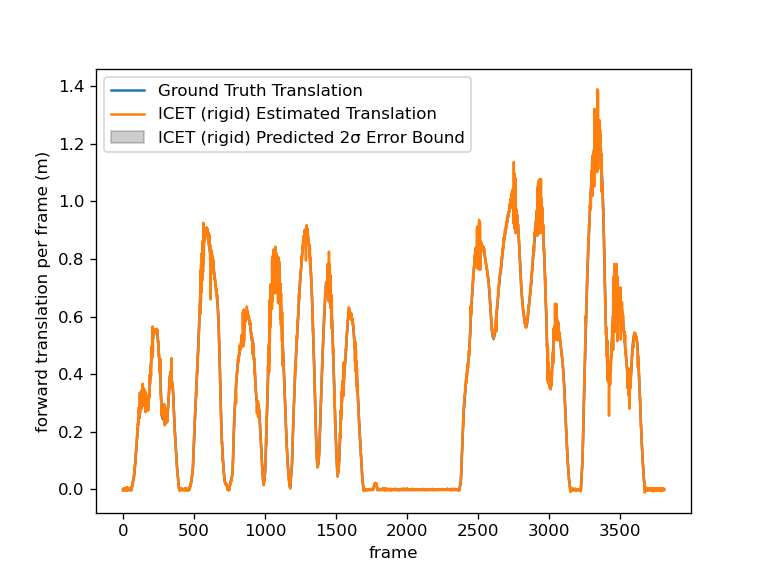

In [211]:
#load ground truth data and rigid transform ICET results
estimates = np.loadtxt("../results/Ford_full_estimates_v10.txt")
pred_stds = np.loadtxt("../results/Ford_full_pred_stds_v10.txt")
ground_truth = np.loadtxt("../spherical_paper/FORD_results/truth_body_frame.txt") # [0, v_xandy, v_vertical, r, p, y]
runlen = np.shape(estimates)[0]
estimates = estimates[1:,:]
pred_stds = pred_stds[1:,:]
vf = (ground_truth[:runlen-1,1]/10 + ground_truth[1:runlen,1]/10)/2 #v5

#plot ground truth vs raw ICET estimates
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(vf, label = 'Ground Truth Translation')
# print(estimates[:,0])
ax.plot(estimates[:,1], label = "ICET (rigid) Estimated Translation") #was this
#NOTE-- adjust linspace here when shifting
ax.fill_between(np.linspace(0,runlen-2,runlen-1),
                   vf - 2*pred_stds[:,1], vf + 2*pred_stds[:,1], 
                   color = [0,0,0], alpha = 0.2, label = 'ICET (rigid) Predicted 2σ Error Bound')
ax.set_xlabel("frame")
ax.set_ylabel("forward translation per frame (m)")
ax.legend(loc = 'best')

In [264]:
from linear_corrector import LC
import mat4py

start_idx = 990 #start on this scan
runlen = 10 #250
m_hat_history = np.zeros([runlen, 6])
X_hat_history = np.zeros([runlen, 6])

A0 = np.array([0., 0, 0, 0, 0, 0,
               0., 0, 0, 0, 0, 0])

for i in range(runlen):
    print("---------------------------------- SCAN IDX", i + start_idx,"-------------------------------------")

    #load point clouds
    fn1 = '/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/Scan%04d.mat' %(i+start_idx+75)
    fn2 = '/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/Scan%04d.mat' %(i+start_idx+76)
    dat1 = mat4py.loadmat(fn1)
    SCAN1 = dat1['SCAN']
    pc1 = np.transpose(np.array(SCAN1['XYZ']))
    dat2 = mat4py.loadmat(fn2)
    SCAN2 = dat2['SCAN']
    pc2 = np.transpose(np.array(SCAN2['XYZ']))

    #align point clouds using ground truth
    ground_truth = np.loadtxt("/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/FORD_DS1_truth.txt")/10
    ground_truth = tf.cast(tf.convert_to_tensor(ground_truth), tf.float32)
    gt = (ground_truth[i+start_idx,:] + ground_truth[i+start_idx+1,:])/2 #avg between pts
        
    #flip order in which points appear in each cloud (so scanner spins ccw in stead of cw)
    pc1 = np.flip(pc1, axis = 0)
    pc2 = np.flip(pc2, axis = 0)
    #need to rotate point clouds so the scan starts aligned with +x axis
    rot = R_tf(np.array([0,0,-np.pi/2])).numpy()
    pc1 = pc1 @ rot
    pc2 = pc2 @ rot

#     #apply "ground truth" transform to point clouds
#     trans = np.array([gt[1], gt[0], gt[2]])
#     trans[0] += 0.01 #add noise to x
#     rot = R_tf(-gt[3:]).numpy().T
#     pc2_transformed =  (pc2 @ rot) + trans 
    
#     print("\n trans, rot GT: \n", trans, -gt[3:].numpy())

    
#     #apply output of ICET to raw point clouds ~~~~~~~~~~~~~~~~~~~
#     #align point clouds using ICET output, seed ICET input with ground truth to ensure convergence
#     it = ICET(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 10, 
#            draw = False, group = 2, RM = True, DNN_filter = False, x0 = gt)
#     #ViewInteractiveWidget(it.plt.window)
#     gt = it.X
#     trans = it.X[:3].numpy()
#     rot = R_tf(-it.X[3:]).numpy().T
#     pc2_transformed =  (pc2 @ rot) + trans 
#     print("\n trans, rot it.X \n", trans, -it.X[3:].numpy())
#     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
#     #run 12 State Rigid Transform + Distortion Correction
#     dc = LC(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 25, 
#         draw = False, mnp = 25, RM = True, solver = '12_state', max_buffer = 1.0)
    
    noise = 0.05*np.random.randn()
    A0 = np.array([gt[1]+noise, 0, 0, 0, 0, 0,
                   0,           0, 0, 0, 0, 0])
    #run 12 State Rigid Transform + Distortion Correction
    dc = LC(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 15, A0 = A0,
        draw = False, mnp = 50, RM = True, solver = '12_state', 
            max_buffer = 0.3)

#     A0[:6] = dc.A[:6]

#     print(dc.m_hat)
    X_hat_history[i,:] = dc.A[:6]
    m_hat_history[i,:] = dc.A[6:]


---------------------------------- SCAN IDX 990 -------------------------------------
A0:
 [0.01157378 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
H: 
 tf.Tensor([209   3  12], shape=(3,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.0131 -0.0021 -0.0004  0.0003 -0.0005 -0.    ] 
 [ 0.0011 -0.0012 -0.0007 -0.0007  0.0004 -0.    ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
H: 
 tf.Tensor([208   3  12], shape=(3,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.0137 -0.0045 -0.001   0.0002 -0.0007 -0.0004] 
 [ 0.0015 -0.0025  0.001  -0.0006  0.0007  0.0005]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
H: 
 tf

num corr: 
 tf.Tensor([192], shape=(1,), dtype=int32)
H: 
 tf.Tensor([192   3  12], shape=(3,), dtype=int32)
LUT tf.Tensor([192   3   3], shape=(3,), dtype=int32)

 residuals (576, 1)

 delta_A
 (12,)
A: 
 [-1.172e-01 -7.010e-02  1.000e-04 -5.000e-04 -1.300e-03  5.600e-02] 
 [-0.0313 -0.0426  0.0053  0.0007  0.0016 -0.0448]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
num corr: 
 tf.Tensor([188], shape=(1,), dtype=int32)
H: 
 tf.Tensor([188   3  12], shape=(3,), dtype=int32)
LUT tf.Tensor([188   3   3], shape=(3,), dtype=int32)

 residuals (564, 1)

 delta_A
 (12,)
A: 
 [-0.107  -0.0992  0.0019 -0.0006 -0.0011  0.042 ] 
 [-0.023  -0.0609  0.0027  0.0008  0.0012 -0.0287]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
num corr: 
 tf.Tensor([193], shape=(1,), dtype=int32)
H: 
 tf.Tensor([193   3  12], shape=(3,), dtype=int32)
LUT tf.Tensor([193   3   3], shape=(3,), dtype=int32)

 residuals (579, 1)

 delta_A
 (12,)
A: 
 [-1.186e-01 -1.259e-01 -1.000e-04 -6.000e-04 -1.300e-03  5.020e-02] 
 [-0.03   -0.0771  

num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
H: 
 tf.Tensor([208   3  12], shape=(3,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.1183 -0.0213  0.0014 -0.      0.0009  0.0004] 
 [-0.0204 -0.0068 -0.0023  0.0005 -0.0012 -0.0015]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
H: 
 tf.Tensor([208   3  12], shape=(3,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.1163 -0.0268  0.0013  0.      0.0009  0.0005] 
 [-0.0215 -0.0094 -0.0021  0.0004 -0.0012 -0.0015]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
H: 
 tf.Tensor([207   3  12], shape=(3,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.1146 -0.0332  0.0012  0.      0.0009  0.0006] 
 [-0.0224 -0.0126 -0.0021  0.0003 -0.0012 -0.0013]
~~~~~~

num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
H: 
 tf.Tensor([208   3  12], shape=(3,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.0489 -0.0247 -0.0004 -0.      0.0004 -0.0013] 
 [-0.0005 -0.0132  0.0013  0.      0.      0.002 ]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
H: 
 tf.Tensor([208   3  12], shape=(3,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.0495 -0.0255 -0.0005 -0.      0.0004 -0.0013] 
 [-0.     -0.0137  0.0014  0.      0.      0.0018]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
H: 
 tf.Tensor([208   3  12], shape=(3,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.05   -0.0262 -0.0005 -0.      0.0004 -0.0013] 
 [ 0.0003 -0.0142  0.0015  0.      0.      0.0018]
----

num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
H: 
 tf.Tensor([205   3  12], shape=(3,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.179  -0.052   0.0043 -0.0004  0.0006 -0.0095] 
 [ 0.0288 -0.0337 -0.0129 -0.0001 -0.0014  0.0125]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
H: 
 tf.Tensor([205   3  12], shape=(3,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.1876 -0.0569  0.005  -0.0004  0.0007 -0.0113] 
 [ 0.0344 -0.0373 -0.0145 -0.0001 -0.0015  0.0155]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
H: 
 tf.Tensor([205   3  12], shape=(3,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.1982 -0.0601  0.0062 -0.0005  0.0008 -0.0127] 
 [ 0.0413 -0.0403 -0.0172 -0.     -0.0018  0.0173]
~~~~~~

A0:
 [-0.00617334  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
H: 
 tf.Tensor([206   3  12], shape=(3,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [-0.0024 -0.0059 -0.001   0.0004 -0.0001  0.0028] 
 [ 0.0028 -0.0041  0.0016 -0.0004  0.0003 -0.001 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
H: 
 tf.Tensor([205   3  12], shape=(3,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [-0.0032 -0.0078 -0.0034  0.0005 -0.0005  0.0049] 
 [ 0.0024 -0.0051  0.0066 -0.0004  0.001  -0.0016]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
H: 
 tf.Tensor([204   3  12], shape=(3,), dtype=int32)
LUT tf.Tensor([204   3   3

num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
H: 
 tf.Tensor([199   3  12], shape=(3,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.151   0.16   -0.0016  0.0011 -0.0004 -0.0241] 
 [-0.0079  0.0981 -0.0048 -0.0007 -0.0004  0.0034]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
num corr: 
 tf.Tensor([198], shape=(1,), dtype=int32)
H: 
 tf.Tensor([198   3  12], shape=(3,), dtype=int32)
LUT tf.Tensor([198   3   3], shape=(3,), dtype=int32)

 residuals (594, 1)

 delta_A
 (12,)
A: 
 [ 0.163   0.1903 -0.0015  0.0012 -0.0003 -0.025 ] 
 [-0.0004  0.1138 -0.0072 -0.0009 -0.0008  0.0011]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
num corr: 
 tf.Tensor([196], shape=(1,), dtype=int32)
H: 
 tf.Tensor([196   3  12], shape=(3,), dtype=int32)
LUT tf.Tensor([196   3   3], shape=(3,), dtype=int32)

 residuals (588, 1)

 delta_A
 (12,)
A: 
 [ 1.719e-01  2.089e-01  7.000e-04  1.300e-03 -1.000e-04 -2.590e-02] 
 [ 0.005   0.1231 -0.012  -0.0012 -0.

<IPython.core.display.Javascript object>


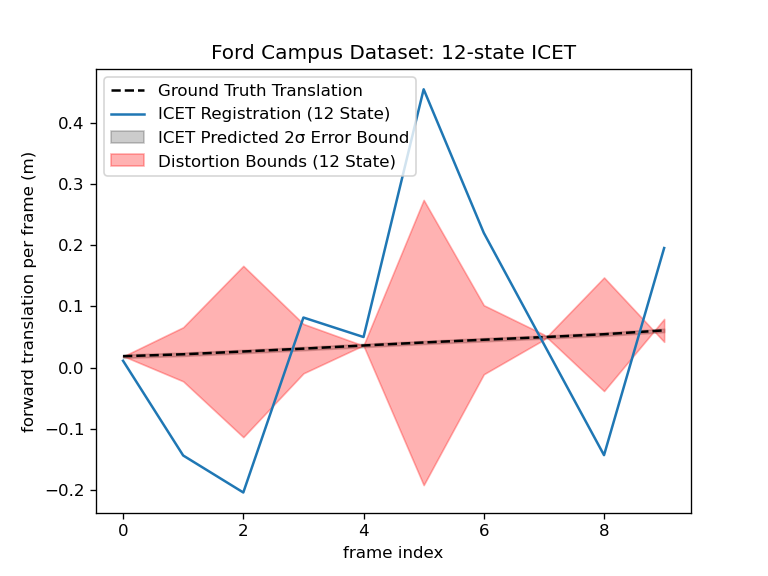

In [265]:
#plot updated bounds
pred_stds = np.loadtxt("../results/Ford_full_pred_stds_v10.txt")
pred_stds = pred_stds[(start_idx):(start_idx+runlen),:]

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
vf = (ground_truth[(start_idx+1):(start_idx+runlen+1),1] + ground_truth[start_idx:(start_idx+runlen),1])/2 #v5

ax.plot(vf, 'k--', label = 'Ground Truth Translation')
# ax.plot(estimates[start_idx:(start_idx+runlen),1], label = "ICET Estimated Translation (rigid)") #old rigid

ax.plot(X_hat_history[:,0], label = "ICET Registration (12 State)")

ax.fill_between(np.linspace(0,runlen-1,runlen),
                   vf - 2*pred_stds[:,1], vf + 2*pred_stds[:,1], 
                   color = [0,0,0], alpha = 0.2, label = 'ICET Predicted 2σ Error Bound')

ax.fill_between(np.linspace(0,runlen-1,runlen),
                   vf - m_hat_history[:,0], vf + m_hat_history[:,0], 
                   color = [1,0,0], alpha = 0.3, label = 'Distortion Bounds (12 State)')
ax.set_title("Ford Campus Dataset: 12-state ICET")
ax.set_xlabel("frame index")
ax.set_ylabel("forward translation per frame (m)")
ax.legend(loc = 'best')

In [ ]:
print(X_hat_history[:,0])